Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

In [18]:
def get_font_family():
    import platform
    system_name = platform.system()
    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    elif system_name == "Linux":
        font_family = "NanumGothic"
    return font_family


font_family = get_font_family()
plt.style.use('seaborn')
plt.rc("font", family=font_family)
plt.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format='retina'

# Chapter 8 - Multi-Factor Models

이 장은 다양한 팩터 모델을 추정하는 데 중점을 둡니다. **팩터**는 과거에 (미래의) 주식 수익률과 상관관계가 있었고, 미래에도 동일한 예측 신호를 포함할 것으로 예상되는 변수/속성입니다.

이러한 위험 요인은 특정 포트폴리오 또는 자산의 초과 수익률(무위험 이자율 초과)을 설명하는 도구로 간주될 수 있습니다. 다양한 **팩터 모델**은 이러한 초과 수익률을 설명하는 데 사용됩니다. 팩터를 리스크의 원천으로 생각할 수 있으며, 이는 초과 수익률의 동인이 됩니다. 각 팩터는 위험 프리미엄을 가지며, 전체 포트폴리오/자산의 수익률은 이러한 프리미엄의 가중 평균입니다.

팩터 모델은 포트폴리오 관리에서 중요한 역할을 합니다. 주요 이유는 다음과 같습니다:

- 투자 포트폴리오에 추가할 수 있는 흥미로운 자산을 식별하는 데 사용될 수 있으며, 이는 더 나은 성과를 내는 포트폴리오로 이어질 수 있습니다.
- 포트폴리오/자산의 팩터에 대한 노출을 추정하면 더 나은 리스크 관리를 할 수 있습니다.
- 새로운 위험 팩터를 추가하는 잠재적인 부가 가치를 평가하는 데 모델을 사용할 수 있습니다.
- 팩터의 수가 적은 모델을 사용하여 여러 자산의 수익률을 요약하면 공분산 행렬을 추정하는 데 필요한 데이터의 양을 줄일 수 있어 포트폴리오 최적화를 용이하게 합니다.
- 팩터는 포트폴리오 관리자의 성과를 평가하는 데 사용될 수 있습니다. 즉, 성과가 자산 선택 및 거래 시점으로 인한 것인지, 또는 알려진 수익률 동인(팩터)에 대한 노출로 인한 것인지를 평가할 수 있습니다.

이 장이 끝날 때쯤, 우리는 가장 대중적인 팩터 모델 중 일부를 구축할 것입니다. 가장 간단하지만 매우 대중적인 **자본자산 가격결정 모델**(CAPM)로 시작하여, 해당 팩터가 시장 수익률일 때의 모델을 설명한 후, 더 발전된 3-팩터, 4-팩터, 5-팩터 모델을 추정하는 방법을 설명할 것입니다. 또한 이러한 팩터가 의미하는 바와 이들이 어떻게 구성되는지에 대한 고차원적인 개요도 제공합니다.

이 장에서는 다음을 다룹니다:

- CAPM 추정
- Fama-French 3-팩터 모델 추정
- 자산 포트폴리오에 대한 롤링 3-팩터 모델 추정
- 4-팩터 및 5-팩터 모델 추정
- Fama-MacBeth 회귀를 사용한 횡단면 팩터 모델 추정

## 8.1 Estimating the CAPM

이 과정에서는 유명한 **자본자산 가격결정 모델(CAPM)** 을 추정하고 베타 계수를 구하는 방법을 배웁니다. 이 모델은 위험 자산의 예상 수익률과 시장 위험(시스템적 또는 분산 불가능한 위험으로도 알려짐) 사이의 관계를 나타냅니다. CAPM은 보다 복잡한 팩터 모델이 구축되는 단일 팩터 모델로 간주될 수 있습니다.

CAPM은 다음 방정식으로 표현됩니다:

$ E(r_i) = r_f + \beta_i (E(r_m) - r_f) $

여기서, $E(r_i)$는 자산 $i$의 예상 수익률을 나타내며, $r_f$는 무위험 이자율(예: 정부 채권 금리)입니다. $E(r_m)$은 시장의 예상 수익률을 나타내며, $\beta_i$는 베타 계수입니다.

베타는 자산 수익률의 민감도를 시장 전체와 비교해 나타낸 것으로 해석할 수 있습니다. 아래는 계수의 가능한 해석입니다:

- $\beta \leq -1$: 자산이 벤치마크와 반대 방향으로 움직이며, 벤치마크보다 더 크게 움직입니다.
- $-1 < \beta < 0$: 자산이 벤치마크와 반대 방향으로 움직입니다.
- $\beta = 0$: 자산의 가격 움직임과 시장 벤치마크 사이에 상관관계가 없습니다.
- $0 < \beta < 1$: 자산이 시장과 같은 방향으로 움직이지만 그 크기는 작습니다. 예를 들어, 일상적인 변동성에 크게 영향을 받지 않는 회사의 주식을 들 수 있습니다.
- $\beta = 1$: 자산과 시장이 동일한 정도로 같은 방향으로 움직입니다.
- $\beta > 1$: 자산이 시장과 같은 방향으로 움직이지만 그 크기는 큽니다. 예를 들어, 일일 시장 뉴스에 매우 민감하게 반응하는 회사의 주식을 들 수 있습니다.

CAPM은 다음과 같이 다시 표현될 수 있습니다:

$ E(r_i) - r_f = \beta_i (E(r_m) - r_f) $

이 방정식의 왼쪽은 위험 프리미엄으로 해석될 수 있으며, 오른쪽은 시장 프리미엄을 포함합니다. 동일한 방정식은 다음과 같이 다시 정리될 수 있습니다:

$
\beta = \frac{cov(R_i, R_m)}{var(R_m)}
$

여기서, $R_i = E(r_i) - r_f$이고, $R_m = E(r_m) - r_f$입니다.

이 예제에서는 Amazon의 경우를 고려하며, S&P 500 지수가 시장을 대표한다고 가정합니다. 우리는 5년(2016~2020)의 월별 데이터를 사용하여 베타를 추정합니다. 최근에는 무위험 이자율이 매우 낮기 때문에 간단하게 무위험 이자율을 0으로 가정합니다.

### How to do it...

1. Import the libraries:

In [2]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

2. Specify the risky asset, the benchmark, and the time horizon:

먼저, 우리가 사용하려는 자산(Amazon 및 S&P 500)과 기간을 지정했습니다. 

In [3]:
RISKY_ASSET = "AMZN"
MARKET_BENCHMARK = "^GSPC"
START_DATE = "2016-01-01"
END_DATE = "2020-12-31"

3. Download data from Yahoo Finance:

**3단계**에서는 Yahoo Finance에서 데이터를 다운로드했습니다. 

In [4]:
# yfinance 라이브러리를 사용하여 Yahoo Finance에서 데이터를 다운로드합니다.
# RISKY_ASSET과 MARKET_BENCHMARK는 각각 위험 자산(Amazon)과 시장 벤치마크(S&P 500)를 나타냅니다.
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                 start=START_DATE,  # 시작 날짜
                 end=END_DATE,      # 종료 날짜
                 adjusted=True,     # 조정된 종가 사용
                 progress=False)    # 진행 상황 표시 비활성화

# 다운로드된 데이터의 행 수를 출력합니다.
print(f'다운로드된 데이터의 행 수: {df.shape[0]}')

# 데이터프레임의 처음 5행을 출력하여 데이터를 확인합니다.
print("\n데이터 샘플:")
print(df.head())

# 데이터프레임의 기본 정보를 출력합니다.
print("\n데이터프레임 정보:")
print(df.info())

다운로드된 데이터의 행 수: 1259

데이터 샘플:
            Adj Close                   Close                    High  \
                 AMZN        ^GSPC       AMZN        ^GSPC       AMZN   
Date                                                                    
2015-12-31  33.794498  2043.939941  33.794498  2043.939941  34.387501   
2016-01-04  31.849501  2012.660034  31.849501  2012.660034  32.886002   
2016-01-05  31.689501  2016.709961  31.689501  2016.709961  32.345501   
2016-01-06  31.632500  1990.260010  31.632500  1990.260010  31.989500   
2016-01-07  30.396999  1943.089966  30.396999  1943.089966  31.500000   

                               Low                    Open               \
                  ^GSPC       AMZN        ^GSPC       AMZN        ^GSPC   
Date                                                                      
2015-12-31  2062.540039  33.794498  2043.619995  34.304001  2060.590088   
2016-01-04  2038.199951  31.375500  1989.680054  32.814499  2038.199951   
2016-01-05

4. Resample to monthly data and calculate simple returns:

그 후, 월별로 마지막 사용 가능한 가격만 유지하고, 월별 수익률을 다음 기간 간의 비율 변화로 계산했습니다.

In [5]:
# 월별 수익률 계산 과정
X = (
    df["Adj Close"]  # 조정 종가 데이터 선택
    .rename(columns={RISKY_ASSET: "asset",  # 위험 자산 열 이름 변경
                     MARKET_BENCHMARK: "market"})  # 시장 벤치마크 열 이름 변경
    .resample("M")  # 월별로 리샘플링
    .last()  # 각 월의 마지막 가격 선택
    .pct_change()  # 월별 수익률 계산 (퍼센트 변화)
    .dropna()  # 결측값 제거
)

# 계산된 월별 수익률의 처음 5행 출력
print("월별 수익률 데이터 (처음 5행):")
print(X.head())

# 기본 통계 정보 출력
print("\n월별 수익률 기본 통계:")
print(X.describe())

# 상관관계 계산
print("\n자산과 시장 간 상관관계:")
print(X.corr())

월별 수익률 데이터 (처음 5행):
               asset    market
Date                          
2016-01-31 -0.131515 -0.050735
2016-02-29 -0.058739 -0.004128
2016-03-31  0.074423  0.065991
2016-04-30  0.111094  0.002699
2016-05-31  0.095817  0.015325

월별 수익률 기본 통계:
           asset     market
count  60.000000  60.000000
mean    0.029985   0.011041
std     0.082746   0.043945
min    -0.202192  -0.125119
25%    -0.020406  -0.001223
50%     0.036104   0.017520
75%     0.081913   0.031376
max     0.268900   0.126844

자산과 시장 간 상관관계:
           asset    market
asset   1.000000  0.639134
market  0.639134  1.000000


5. Calculate beta using the covariance approach: 

**5단계**에서는 위험 자산과 벤치마크 간의 공분산을 벤치마크의 분산으로 나눈 값으로 베타를 계산했습니다.

In [7]:
# 공분산 계산
# X.cov()는 X의 공분산 행렬을 반환하고, iloc[0,1]은 자산과 시장 간의 공분산을 선택합니다.
covariance = X.cov().iloc[0,1]

# 벤치마크(시장) 수익률의 분산 계산
benchmark_variance = X.market.var()

# 베타 계산
# 베타는 자산과 시장 간의 공분산을 시장 수익률의 분산으로 나눈 값입니다.
beta = covariance / benchmark_variance

# 계산된 베타 값 출력
print(f"계산된 베타 값: {beta:.4f}")

계산된 베타 값: 1.2035


6. Prepare the input and estimate CAPM as a linear regression:

**6단계**에서는 **pandas DataFrame**의 pop 메서드를 사용하여 목표(Amazon의 주식 수익률)와 특징(S&P 500 수익률)을 분리했습니다. 그 후 **add_constant** 함수를 사용해 DataFrame에 상수를 추가(1의 열을 추가)했습니다.

이 회귀분석에 절편을 추가하는 아이디어는 모델을 추정한 후 절편(CAPM의 경우 **Jensen's alpha**)이 0인지 조사하는 것입니다. 만약 절편이 양수이고 유의미하다면, 이는 CAPM 모델이 참이라고 가정할 때 자산 또는 포트폴리오가 비정상적으로 높은 위험 조정 수익을 발생시킨다는 것을 의미합니다. 이 문제는 **공동 가설 문제(joint hypothesis problem)** 로 알려져 있습니다.

In [8]:
# 종속 변수(자산 수익률) 분리
# X DataFrame에서 'asset' 열을 추출하여 y에 저장하고, X에서는 제거합니다.
y = X.pop("asset")

# 독립 변수에 상수항 추가
# 회귀 분석을 위해 X DataFrame에 상수항(1로 채워진 열)을 추가합니다.
X = sm.add_constant(X)

# CAPM 회귀 모델 정의 및 적합
# OLS(Ordinary Least Squares) 방법을 사용하여 CAPM 모델을 추정합니다.
capm_model = sm.OLS(y, X).fit()

# 결과 출력
# 추정된 CAPM 모델의 요약 통계를 출력합니다.
# 이 요약에는 계수 추정치, 표준 오차, t-통계량, p-값 등이 포함됩니다.
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     40.05
Date:                Sun, 29 Sep 2024   Prob (F-statistic):           3.89e-08
Time:                        08:14:12   Log-Likelihood:                 80.639
No. Observations:                  60   AIC:                            -157.3
Df Residuals:                      58   BIC:                            -153.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0167      0.009      1.953      0.0

Figure 8.1: The summary of the CAPM estimated using OLS

이 결과에 따르면 베타(여기서는 시장을 나타냄)가 1.2로, 이는 아마존의 수익률이 시장(S&P 500으로 대변됨)보다 20% 더 변동성이 크다는 것을 의미합니다. 다시 말해, 아마존의 초과 수익률은 시장의 초과 수익률에 비해 1.2배만큼 움직일 것으로 예상됩니다. 절편 값은 상대적으로 작고 5% 유의 수준에서 통계적으로 유의미하지 않습니다.

Or, using the formula notation:

>우리는 또한 상수를 자동으로 추가하는 **formula notation**을 사용할 수 있습니다. 이를 위해서는 **statsmodels.formula.api**를 **smf**로 가져오고, 살짝 수정된 다음 줄을 실행해야 합니다: ```python capm_model = smf.ols(formula="asset ~ market", data=X).fit()```

마지막으로, OLS 회귀를 실행하고 요약을 출력했습니다. 여기에서, 시장 변수의 계수(즉, CAPM 베타)가 **5단계**에서 자산과 시장 간의 공분산을 사용하여 계산한 베타와 동일하다는 것을 확인할 수 있었습니다.

In [9]:
# statsmodels.formula.api 모듈을 smf라는 별칭으로 가져옵니다.
import statsmodels.formula.api as smf

# 4단계를 다시 실행하여 'asset'과 'market' 열이 있는 DataFrame을 생성합니다.
X = df["Adj Close"].rename(columns={RISKY_ASSET: "asset", 
                                    MARKET_BENCHMARK: "market"}) \
                   .resample("M") \
                   .last() \
                   .pct_change() \
                   .dropna()

# CAPM 회귀 모델을 정의하고 적합합니다.
# 'asset ~ market' 공식은 asset을 종속 변수로, market을 독립 변수로 사용합니다.
capm_model = smf.ols(formula="asset ~ market", data=X).fit()

# 회귀 분석 결과를 출력합니다.
# 이 결과에는 계수 추정치, 표준 오차, t-통계량, p-값 등이 포함됩니다.
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     40.05
Date:                Sun, 29 Sep 2024   Prob (F-statistic):           3.89e-08
Time:                        08:17:19   Log-Likelihood:                 80.639
No. Observations:                  60   AIC:                            -157.3
Df Residuals:                      58   BIC:                            -153.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0167      0.009      1.953      0.0

이 두 접근 방식은 동일합니다. 


### There's more

위의 예에서, 우리는 무위험 이자율이 없다고 가정했는데, 이는 오늘날 타당한 가정일 수 있습니다. 그러나 무위험 이자율이 0이 아닌 경우를 고려해야 할 상황도 있을 수 있습니다. 이를 위해 우리는 다음 접근 방식을 사용할 수 있습니다.

### Using data from Prof. Kenneth French’s website

**Prof. Kenneth French의 웹사이트에서 데이터를 사용하는 방법**


시장 프리미엄 $(r_m - r_f)$ 및 무위험 이자율(약 1개월 만기 국채 금리)은 Professor Kenneth French의 웹사이트에서 다운로드할 수 있습니다(이 레시피의 **참고** 섹션을 참조해 주세요).

>Professor French가 사용한 시장 벤치마크 정의는 S&P 500 지수와 다르다는 점에 유의해 주세요. 이에 대한 자세한 설명은 그의 웹사이트에서 확인할 수 있습니다. 데이터를 쉽게 다운로드하는 방법에 대한 설명도 함께 제공됩니다.

#### Risk-free rate (13 Week Treasury Bill)

두 번째 옵션은 무위험 이자율을 13주(3개월) 만기 국채(Treasury Bill)로 근사하는 것입니다 (Yahoo Finance 티커: ^IRX). 데이터를 다운로드하고 이를 적절한 무위험 이자율로 변환하는 방법을 배우기 위해 다음 단계를 따르세요:

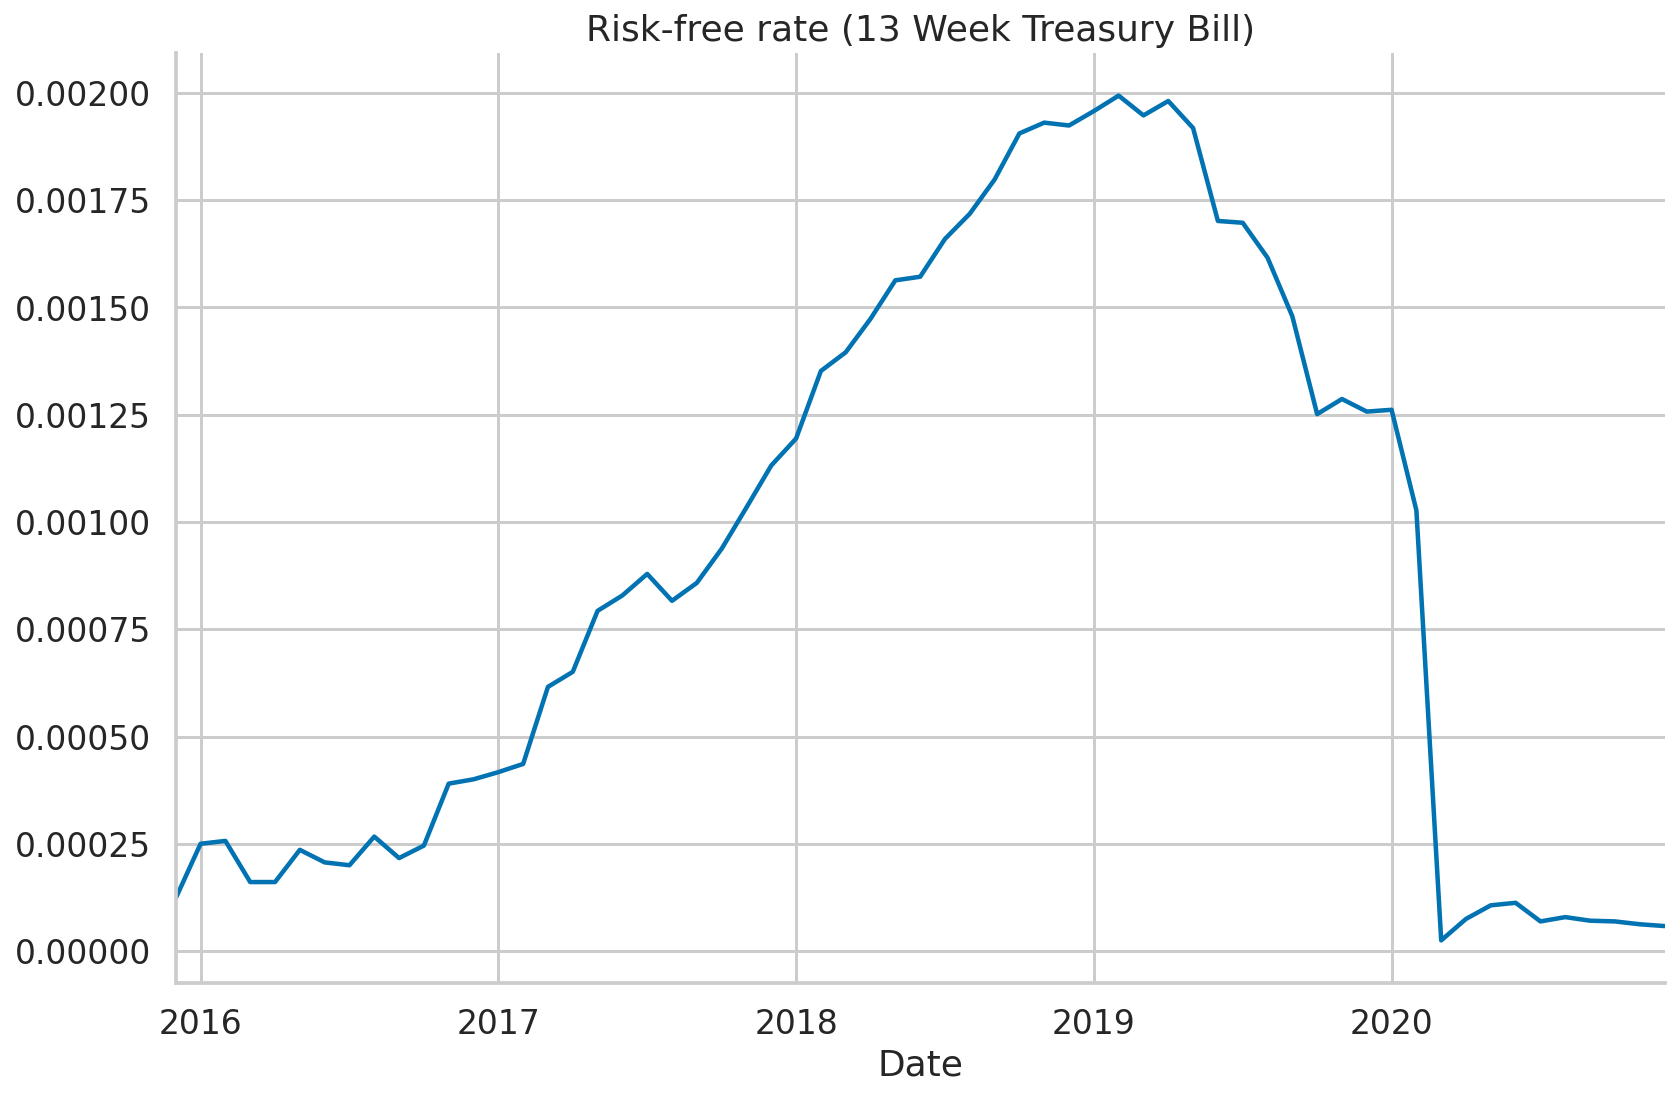

In [14]:
# 기간 길이를 일 단위로 설정 (13주 = 약 90일)
N_DAYS = 90

# Yahoo Finance에서 13주 국채 수익률 데이터 다운로드
# ^IRX는 13주 국채 수익률의 티커 심볼
df_rf = yf.download("^IRX",
                    start=START_DATE,
                    end=END_DATE,
                    progress=False)

# 월별 데이터로 리샘플링 (각 월의 마지막 값 사용)
# Close 열을 선택하고 100으로 나누어 비율로 변환
rf = df_rf.resample("M").last().Close / 100

# 일별 무위험 수익률 계산
# 연간 수익률을 일별 수익률로 변환하는 공식 사용
rf = ( 1 / (1 - rf * N_DAYS / 360) )**(1 / N_DAYS)  

# 일별 수익률을 월별 수익률로 변환 (30일 기준)
# 1을 빼서 수익률 형태로 변환
rf = (rf ** 30) - 1 

# 무위험 이자율 그래프 그리기
rf.plot(title="Risk-free rate (13 Week Treasury Bill)")

# 그래프 테두리 제거 (위쪽과 오른쪽)
sns.despine()

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 저장 (현재 주석 처리됨)
# plt.savefig("images/figure_9_2", dpi=200)

Figure 8.2: The risk-free rate calculated using the 13-Week Treasury Bill

1. **복리의 개념**
복리(Compound Interest)는 **원금뿐만 아니라 이전에 쌓인 이자에도 이자가 붙는 방식**입니다. 시간이 지날수록 이자가 다시 이자를 만들기 때문에, 수익은 점차 가속화됩니다.

- **단리(Simple Interest)**: 원금에 대해서만 이자가 붙음.
- **복리(Compound Interest)**: 이자에 다시 이자가 붙음.

복리 공식은 다음과 같습니다:

$
A = P \left(1 + \frac{r}{n}\right)^{nt}
$

- $ A $: 미래 가치
- $ P $: 원금
- $ r $: 연간 이자율
- $ n $: 이자가 붙는 횟수 (연간)
- $ t $: 기간 (연 단위)

---

2. **일별 무위험 수익률 계산 (연간 수익률에서 일별 수익률로 변환)**
연간 수익률을 일별 수익률로 변환하는 과정에서 복리 개념을 적용해 일별 무위험 수익률을 구합니다. 13주 만기 국채의 연간 수익률을 기반으로 매일 적용되는 이자율을 구하기 위한 단계는 다음과 같습니다.

(1) 90일 동안 발생하는 수익률 계산
연간 수익률을 90일(약 13주) 동안의 수익률로 변환하기 위해 다음 식을 사용합니다:

$
\text{90일 수익률} = rf \times \frac{N\_DAYS}{360}
$

이 값은 90일 동안 발생하는 수익률을 나타냅니다.

(2) 현재 가치에서 미래 가치로 변환 (역수 계산)
90일 후에 받게 될 금액을 현재 가치에서 미래 가치로 변환하기 위해 다음을 계산합니다:

$
\text{미래 가치} = \frac{1}{1 - rf \times \frac{N\_DAYS}{360}}
$


- $ 1 - rf \times \frac{N\_DAYS}{360} $는 **현재 가치**를 나타내며, 이를 역수로 취해 **미래 가치**를 구합니다.

(3) 일별 복리 수익률 계산
90일 후의 미래 가치를 **일별로 나누기 위해** 복리 공식에 따라 거듭제곱을 적용합니다:

$
r_{\text{daily}} = \left( \frac{1}{1 - rf \times \frac{N\_DAYS}{360}} \right)^{\frac{1}{N\_DAYS}}
$

이 과정은 90일 동안의 복리 수익률을 매일의 수익률로 변환하는 것으로, **매일매일 복리가 적용되는 수익률**을 나타냅니다.

---

3. **일별 수익률을 월별 수익률로 변환**
일별로 계산된 무위험 수익률을 월 단위로 변환하기 위한 과정입니다.

(1) 일별 수익률을 30일 동안 복리로 적용
일별 수익률을 30일간 복리로 적용하여 월별 수익률을 계산합니다:

$
r_{\text{monthly}} = (r_{\text{daily}})^{30}
$

매일매일의 이자가 30일 동안 쌓이면서 발생하는 복리 효과를 계산합니다.

(2) 원금과 이자를 분리하여 수익률로 변환
복리 계산된 금액에서 1을 빼서 실제 **월별 수익률**을 얻습니다:

$
r_{\text{monthly}} = (r_{\text{daily}}^{30}) - 1
$

이때 1을 빼는 이유는 원금과 이자를 분리하여 **실제 수익률**만을 얻기 위함입니다.

---

4. **핵심 요약**
- 연간 수익률을 일별 수익률로 변환할 때는 복리 개념을 적용해 **매일의 수익률**을 계산합니다. 이는 역수 계산과 거듭제곱을 통해 이루어집니다.
- 일별 수익률을 다시 30일 기준으로 월별 수익률로 변환할 때도 복리 계산을 통해 **30일 동안 누적된 이자**를 고려하여 월 수익률을 얻습니다.

이 과정을 통해 연간 수익률을 기반으로 일별, 월별 무위험 수익률을 계산하고 분석할 수 있습니다.

이제 전체 흐름이 좀 더 명확해지셨나요? 추가적으로 궁금한 점이나 깊이 설명이 필요한 부분이 있으면 언제든지 질문해주세요!

#### Risk-free rate (3-Month Treasury Bill)

마지막 방법은 3개월 만기 국채(이차 시장 금리)를 사용하여 무위험 이자율을 근사하는 것입니다. 해당 데이터는 Federal Reserve Economic Data(FRED) 데이터베이스에서 다운로드할 수 있습니다. 데이터를 다운로드하고 이를 월별 무위험 이자율로 변환하는 방법을 배우기 위해 다음 단계를 따르세요:

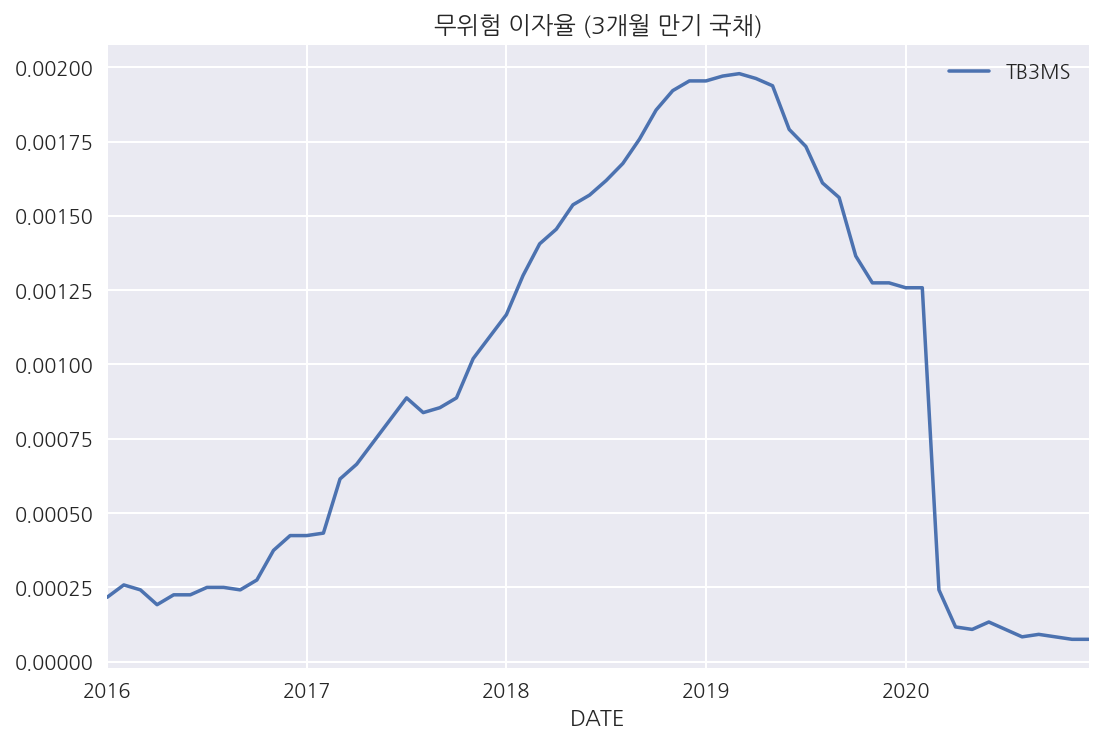

In [19]:
import pandas_datareader.data as web

# FRED에서 3개월 만기 국채 데이터 다운로드
rf = web.DataReader(
    "TB3MS", "fred", start=START_DATE, end=END_DATE
)

# 연간 이자율을 월간 이자율로 변환
# (1 + 연간 이자율)^(1/12) - 1 공식 사용
rf = (1 + (rf / 100)) ** (1 / 12) - 1

# 무위험 이자율 그래프 그리기
rf.plot(title="무위험 이자율 (3개월 만기 국채)")

# 그래프 테두리 제거로 시각적 개선
sns.despine()

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 저장 (필요시 주석 해제)
# plt.savefig("images/figure_9_3", dpi=200)

Figure 8.3: The risk-free rate calculated using the 3-Month Treasury Bill

### See also 

Additional resources are available here: 
- Sharpe, W. F., “Capital asset prices: A theory of market equilibrium under conditions of risk,” The Journal of Finance, 19, 3 (1964): 425–442. 
- Risk-free rate data on Prof. Kenneth French’s website: http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip.

## 8.2 Estimating the Fama-French three-factor model

**Fama-French 3요인 모델 추정**

Fama와 French는 그들의 유명한 논문에서 자산 또는 포트폴리오의 초과 수익률을 설명하기 위해 CAPM 모델에 두 가지 추가 요인을 포함했습니다. 그들이 고려한 요인은 다음과 같습니다:

- **시장 요인(MKT)**: CAPM에서의 요인과 유사하게, 시장의 초과 수익률을 측정합니다.
- **규모 요인(SMB; Small Minus Big)**: 작은 시가총액을 가진 주식이 큰 시가총액을 가진 주식보다 더 높은 초과 수익률을 측정합니다.
- **가치 요인(HML; High Minus Low)**: 가치주가 성장주보다 높은 초과 수익률을 측정합니다. 가치주는 높은 주가 대비 장부가치 비율을 가지며, 성장주는 낮은 비율로 특징지어집니다.

모델은 다음과 같이 표현될 수 있습니다:

$ E(r_i) = r_f + \alpha + \beta_{mkt}(E(r_m) - r_f) + \beta_{smb}SMB + \beta_{hml}HML $

또는 더 간단한 형태로:

$ E(r_i) - r_f = \alpha + \beta_{mkt}MKT + \beta_{smb}SMB + \beta_{hml}HML $

여기서, $E(r_i)$는 자산 $i$의 예상 수익률을 나타내며, $r_f$는 무위험 이자율(예: 정부 채권 금리)입니다. $\alpha$는 절편입니다. 절편을 포함하는 이유는 그 값이 0인지 확인하기 위함입니다. 이는 3요인 모델이 초과 수익률과 요인 간의 관계를 올바르게 평가하는지를 확인합니다.

통계적으로 유의미하고 0이 아닌 절편이 있는 경우, 모델이 자산/포트폴리오 수익률을 올바르게 평가하지 못할 수 있습니다. 그러나 저자들은 3요인 모델이 통계적 검정을 통과하지 못하더라도 "상당히 정확하다"라고 언급했습니다.

이 접근 방식의 인기로 인해, 이러한 요인들은 **Fama-French 요인** 또는 **3요인 모델**로 널리 알려지게 되었습니다. 이 요인들은 학계와 산업계에서 널리 받아들여졌으며, 종종 투자 성과를 평가하는 데 사용됩니다.

이 레시피에서는 Apple 주식의 월간 수익률을 사용하여 5년(2016년 ~ 2020년) 동안 3요인 모델을 추정합니다.

### How to do it...

1. Import the libraries:

In [20]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Define parameters:

첫 번째와 두 번째 단계에서는 필요한 라이브러리를 가져오고 매개변수를 정의했습니다. 여기서 위험 자산은 Apple 주식이고, 고려된 기간을 정의했습니다.

In [21]:
RISKY_ASSET = "AAPL"
START_DATE = "2016-01-01"
END_DATE = "2020-12-31"

3. Download the dataset containing the risk factors:

**3단계**에서는 **pandas_datareader** 라이브러리의 기능을 사용하여 데이터를 다운로드했습니다. 어떤 데이터를 사용할 것인지 지정해야 했습니다(사용 가능한 데이터셋을 검사하는 방법은 "추가 사항" 섹션에서 설명됩니다). 기본적으로 **web.DataReader**는 지난 5년간의 데이터를 다운로드합니다.

In [23]:
# Fama-French 요인 데이터를 다운로드합니다.
# web.DataReader 함수를 사용하여 "F-F_Research_Data_Factors" 데이터셋을 가져옵니다.
# 'famafrench'는 데이터 소스를 지정합니다.
# start와 end 매개변수로 데이터 기간을 설정합니다.
ff_dict = web.DataReader("F-F_Research_Data_Factors", 
                         "famafrench", 
                         start=START_DATE,
                         end=END_DATE)

다운로드된 딕셔너리는 세 가지 요소를 포함합니다: 요청된 기간의 월별 요인(인덱스 0), 해당하는 연간 요인(인덱스 1), 그리고 데이터셋에 대한 간단한 설명(인덱스 DESCR).

In [24]:
ff_dict.keys()

dict_keys([0, 1, 'DESCR'])

In [25]:
print(ff_dict['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202407 CRSP database. The 1-month TBill rate data until 202405 are from Ibbotson Associates. Starting from 202406, the 1-month TBill rate is from ICE BofA US 1-Month Treasury Bill Index. Copyright 2024 Kenneth R. French

  0 : (60 rows x 4 cols)
  1 : Annual Factors: January-December (5 rows x 4 cols)


4. Select the appropriate dataset and divide the values by 100:

**4단계**에서는 월별 값만 포함된 데이터셋을 선택하고, 다운로드된 딕셔너리에서 값이 0인 데이터를 필터링했습니다. MKT 요인이 포함된 열의 이름을 변경한 후, 모든 값을 100으로 나누어 값을 인코딩했습니다. 예를 들어, 데이터셋에서 3.45의 값은 3.45%를 나타냅니다.

In [26]:
# Fama-French 3요인 데이터프레임을 생성합니다.
factor_3_df = ff_dict[0].rename(columns={"Mkt-RF": "MKT"}) \
                        .div(100)

# 'Mkt-RF' 열의 이름을 'MKT'로 변경합니다.
# 모든 값을 100으로 나누어 백분율을 소수점으로 변환합니다.

# 데이터프레임의 처음 5행을 출력하여 결과를 확인합니다.
factor_3_df.head()

,MKT,SMB,HML,RF
Date,,,,
2016-01,-0.0577,-0.0342,0.0209,0.0001
2016-02,-0.0007,0.0074,-0.0057,0.0002
2016-03,0.0696,0.0082,0.0119,0.0002
2016-04,0.0091,0.0076,0.0328,0.0001
2016-05,0.0178,-0.0017,-0.0166,0.0001


Figure 8.4: Preview of the downloaded factors

5. Download the prices of the risky asset:

**5단계**와 **6단계**에서는 Apple 주식의 월별 데이터를 다운로드하고 처리했습니다. 월말 가격의 비율 변화를 계산하여 월별 수익률을 얻었습니다.

In [28]:
# yfinance를 사용하여 위험 자산의 가격 데이터를 다운로드합니다
asset_df = yf.download(RISKY_ASSET,  # 위험 자산의 티커 심볼
                       start=START_DATE,  # 데이터 시작일
                       end=END_DATE,  # 데이터 종료일
                       adjusted=True,  # 수정주가 사용
                       progress=False)  # 진행 상황 표시 비활성화

# 다운로드된 데이터의 행 수를 출력합니다
print(f"다운로드된 데이터: {asset_df.shape[0]}행")

다운로드된 데이터: 1259행


6. Calculate monthly returns on the risky asset:

**6단계**에서는 Fama-French 요인들이 포함된 인덱스의 형식에에 맞게 데터의 인덱스를 **YYYY-MM**(예: 2000-12)로 변경했습니다.

In [30]:
# 월별 수익률 계산
y = asset_df["Adj Close"].resample("M") \
                         .last() \
                         .pct_change() \
                         .dropna()

# 인덱스를 월 단위 기간으로 변경
y.index = y.index.to_period("m")

# 시리즈 이름을 'rtn'으로 설정
y.name = "rtn"

# 처음 5개 행 출력
y.head()

Date
2016-01   -0.075242
2016-02   -0.001287
2016-03    0.127211
2016-04   -0.139921
2016-05    0.071773
Freq: M, Name: rtn, dtype: float64

7. Merge the datasets and calculate excess returns:

In [31]:
# 팩터 데이터프레임에 주식 수익률 데이터를 결합합니다
factor_3_df = factor_3_df.join(y)

# 초과 수익률을 계산합니다
# 초과 수익률 = 주식 수익률 - 무위험 수익률
factor_3_df["excess_rtn"] = (
    factor_3_df["rtn"] - factor_3_df["RF"]
)

# 결과 데이터프레임의 처음 5행을 출력합니다
factor_3_df.head()

,MKT,SMB,HML,RF,rtn,excess_rtn
Date,,,,,,
2016-01,-0.0577,-0.0342,0.0209,0.0001,-0.075242,-0.075342
2016-02,-0.0007,0.0074,-0.0057,0.0002,-0.001287,-0.001487
2016-03,0.0696,0.0082,0.0119,0.0002,0.127211,0.127011
2016-04,0.0091,0.0076,0.0328,0.0001,-0.139921,-0.140021
2016-05,0.0178,-0.0017,-0.0166,0.0001,0.071773,0.071673


8. Estimate the three-factor model:

마지막으로 **8단계**에서는 회귀 분석을 실행했습니다. 이때 절편을 수동으로 추가할 필요가 없었습니다. 언급할만한 한 가지 중요한 점은, MKT 변수의 계수가 CAPM의 베타와 동일하지 않다는 것입니다. 이는 모델에 다른 요인들도 포함되어 있기 때문이며, 그 요인들이 초과 수익에 미치는 영향이 다르게 분배되기 때문입니다.

In [35]:
# Fama-French 3요인 모델을 정의하고 적합합니다
# 종속변수: excess_rtn (초과 수익률)
# 독립변수: MKT (시장 요인), SMB (규모 요인), HML (가치 요인)
ff_model = smf.ols(formula="excess_rtn ~ MKT + SMB + HML", 
                   data=factor_3_df).fit()

# 모델 요약 결과를 출력합니다
# 이 결과에는 계수 추정치, 표준 오차, t-통계량, p-값 등이 포함됩니다
print(ff_model.summary())

# 주의: 결과 해석 시 다음 사항을 고려하세요
# 1. 절편의 부호와 통계적 유의성
# 2. 각 요인의 통계적 유의성과 영향의 방향
# 3. 모델의 전반적인 적합도 (R-squared, F-통계량 등)

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     19.15
Date:                Sun, 29 Sep 2024   Prob (F-statistic):           1.14e-08
Time:                        09:26:56   Log-Likelihood:                 82.838
No. Observations:                  60   AIC:                            -157.7
Df Residuals:                      56   BIC:                            -149.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0084      0.009      0.956      0.3

Figure 8.5: The summary of the estimated three-factor model

3요인 모델의 결과를 해석할 때, 우리는 두 가지 문제에 주목해야 합니다:

- 절편이 양수이며 통계적으로 유의미한지 여부
- 어떤 요인이 통계적으로 유의미하며, 그 방향이 과거 연구(예: 문헌 연구)나 우리의 가정과 일치하는지 여부

우리의 경우, 절편은 양수이지만 5% 유의 수준에서는 통계적으로 유의미하지 않습니다. 위험 요인 중에서 SMB 요인만이 유의미하지 않습니다. 그러나 요인과 그 영향 방향에 대한 가설을 수립하기 위해서는 철저한 문헌 연구가 필요합니다. 회귀에서 제시된 F-통계량도 볼 수 있습니다. 이는 회귀의 공동 유의성을 테스트합니다. 영가설은 모든 특징(이 경우 요인)의 계수가 0과 같다는 것을 나타냅니다. 5% 유의 수준에서 영가설을 기각할 수 있는 이유는 p-값이 0.05보다 훨씬 낮기 때문입니다.

### There's more

다음 코드 스니펫을 사용하여 `pandas_datareader`를 통해 Fama-French 카테고리에서 다운로드 가능한 데이터 세트를 확인할 수 있습니다. 

약 300개의 데이터 세트 중에서 간결하게 5개만 표시합니다:

Print available datasets (here only first 5):

In [36]:
from pandas_datareader.famafrench import get_available_datasets

get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

### Bonus

이전 책 버전에서는 Jupyter 노트북 내에서 간단한 Bash 명령을 사용하여 French 교수의 웹사이트에서 CSV 파일을 직접 다운로드하는 방법도 보여드렸습니다. 이를 설명하는 코드는 함께 제공된 노트북에서 찾을 수 있습니다.

1. Download data from prof. French's website:

이를 위해 Jupyter 노트북에서 명령 앞에 `!`를 붙여 bash 명령을 실행할 수 있다는 사실을 이용했습니다. 먼저 `wget`을 사용해 파일을 다운로드한 후, `unzip`을 사용해 압축을 해제했습니다. Python만으로도 이 작업을 수행할 수 있는 방법이 있지만, 여기서는 노트북에 bash 스크립트를 혼합할 수 있는 가능성을 소개하기에 좋은 기회라고 판단했습니다. 월별 데이터에 대한 링크는 항상 동일하며, 파일은 매달 업데이트됩니다.

In [35]:
# # download the zip file from Prof. French's website
# !wget http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip

# # unpack the zip file
# !unzip -a F-F_Research_Data_Factors_CSV.zip

# # remove the zip file
# !rm F-F_Research_Data_Factors_CSV.zip

2. Load data from the source CSV file and keep only the monthly data:

In [37]:
# CSV 파일에서 데이터 로드
# 참고: 파일 이름이 대문자 CSV로 되어있어 수정했습니다.
factor_3_df = pd.read_csv("F-F_Research_Data_Factors.CSV", skiprows=3)

# 연간 데이터의 시작 위치 식별
# 연간 데이터는 "Annual Factors: January-December" 문자열로 시작합니다.
STR_TO_MATCH = " Annual Factors: January-December "
indices = factor_3_df.iloc[:, 0] == STR_TO_MATCH
start_of_annual = factor_3_df[indices].index[0]

# 월별 데이터만 유지
# 연간 데이터 시작 위치 이전의 데이터만 선택합니다.
factor_3_df = factor_3_df[factor_3_df.index < start_of_annual]

# 이제 factor_3_df에는 월별 데이터만 포함되어 있습니다.

3. Rename columns of the DataFrame, set a datetime index and filter by dates:

In [38]:
# 데이터프레임의 열 이름을 변경합니다
factor_3_df.columns = ["date", "mkt", "smb", "hml", "rf"]

# 날짜 문자열을 datetime 객체로 변환하고 'YYYY-MM' 형식으로 다시 포맷팅합니다
factor_3_df["date"] = (
    pd.to_datetime(factor_3_df["date"], format="%Y%m")  # 'YYYYMM' 형식의 문자열을 datetime으로 변환
    .dt.strftime("%Y-%m")  # 'YYYY-MM' 형식의 문자열로 다시 변환
)

# 'date' 열을 인덱스로 설정합니다
factor_3_df = factor_3_df.set_index("date")

# 지정된 시작 날짜와 종료 날짜 사이의 데이터만 필터링합니다
factor_3_df = factor_3_df.loc[START_DATE:END_DATE]

4. Convert the values to numeric and divide by 100:

In [39]:
# 데이터프레임의 모든 열을 숫자형으로 변환합니다.
# 'errors="coerce"'는 변환할 수 없는 값을 NaN으로 처리합니다.
factor_3_df = factor_3_df.apply(pd.to_numeric, errors="coerce")

# 모든 값을 100으로 나눕니다.
# 이는 퍼센트 값을 소수점 형태로 변환하는 것입니다.
factor_3_df = factor_3_df.div(100)

# 변환된 데이터프레임의 첫 5행을 출력합니다.
# 이를 통해 변환이 제대로 이루어졌는지 확인할 수 있습니다.
factor_3_df.head()

,mkt,smb,hml,rf
date,,,,
2016-02,-0.0007,0.0074,-0.0057,0.0002
2016-03,0.0696,0.0082,0.0119,0.0002
2016-04,0.0091,0.0076,0.0328,0.0001
2016-05,0.0178,-0.0017,-0.0166,0.0001
2016-06,-0.0005,0.0061,-0.0148,0.0002


### See also 

Additional resources: 
- For details on how all the factors were calculated, please refer to Prof. French’s website at http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_factors.html 
- Fama, E. F., and French, K. R., “Common risk factors in the returns on stocks and bonds,” Journal of Financial Economics, 33, 1 (1993): 3-56

## 8.3 Estimating the rolling three-factor model on a portfolio of assets

이번 레시피에서는 3요인 모델을 롤링 방식으로 추정하는 방법을 배웁니다. 여기서 롤링이란, 항상 일정한 크기의 추정 윈도우(이 경우 60개월)를 고려하고, 데이터를 한 기간씩 이동하며 전체 데이터셋을 통해 이 과정을 반복하는 것을 의미합니다. 이러한 실험을 수행하는 잠재적인 이유는 결과의 안정성을 테스트하기 위함입니다. 대안적으로, 이 연습에서는 확장 창(expanding window)을 사용할 수도 있습니다. 

이전 레시피와는 달리, 이번에는 개별 자산 대신 포트폴리오 수익률을 사용합니다. 간단하게 하기 위해, 우리는 포트폴리오의 전체 가치를 다음 주식에 동등하게 배분하는 전략을 가정합니다: Amazon, Google, Apple, Microsoft. 이 실험에서는 2010년부터 2020년까지의 주가 데이터를 사용합니다.


### How to do it...

1. Import the libraries:

In [41]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Define the parameters:

In [42]:
ASSETS = ["AMZN", "GOOG", "AAPL", "MSFT"]
WEIGHTS = [0.25, 0.25, 0.25, 0.25]
START_DATE = "2010-01-01"
END_DATE = "2020-12-31"

3. Download the factor related data:

In [43]:
factor_3_df = web.DataReader("F-F_Research_Data_Factors", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]
factor_3_df = factor_3_df.div(100)

4. Download the prices of risky assets from Yahoo Finance:

**3단계**와 **4단계**에서는 **pandas_datareader**와 **yfinance**를 사용하여 데이터를 다운로드했습니다. 이는 **Fama-French 3요인 모델 추정** 레시피에서 했던 것과 매우 유사하므로, 여기서는 이에 대한 자세한 설명은 생략하겠습니다.

In [50]:
# yfinance를 사용하여 주식 데이터 다운로드
asset_df = yf.download(ASSETS,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,  # 배당금과 주식 분할을 고려한 수정주가 사용
                       progress=False)  # 진행 상황 표시 비활성화

# 다운로드된 데이터의 행 수 출력
print(f"다운로드된 데이터의 행 수: {asset_df.shape[0]}")

다운로드된 데이터의 행 수: 2769


5. Calculate the monthly returns on the risky assets:

In [51]:
# 월별 수익률 계산
# 1. "Adj Close" 열을 선택하여 수정 종가 데이터만 사용
# 2. 'M'(월) 기준으로 리샘플링하여 월별 데이터로 변환
# 3. last() 메서드로 각 월의 마지막 거래일 가격 선택
# 4. pct_change()로 전월 대비 변화율(수익률) 계산
# 5. dropna()로 결측값 제거
asset_df = asset_df["Adj Close"].resample("M") \
                                .last() \
                                .pct_change() \
                                .dropna()

# 인덱스를 월 단위 기간으로 변환
# 이는 나중에 다른 데이터와 결합할 때 유용함
# to_period("m")을 사용하여 날짜를 월 단위 기간으로 변환
asset_df.index = asset_df.index.to_period("m")

6. Calculate the portfolio returns:

**6단계**에서는 포트폴리오 구성 자산의 수익률을 가중 평균으로 계산하여 포트폴리오 수익률을 구했습니다(이는 **5단계**에서 계산되었습니다). 우리는 간단한 수익률을 사용하여 작업 중이므로, 자세한 내용은 **2장, 데이터 전처리 - 가격을 수익률로 변환** 레시피를 참조하세요. 이 간단한 접근 방식은 각 달 말에 동일한 자산 배분(가중치에 의해 표시된 대로)을 가지고 있다고 가정합니다. 이는 **포트폴리오 리밸런싱(재조정)** 을 통해 달성할 수 있습니다. 즉, 특정 기간 이후 배분을 조정하여 항상 의도된 가중치 분배와 일치하도록 합니다.

In [52]:
# 포트폴리오 수익률 계산
# 1. asset_df[ASSETS].values로 자산 수익률 행렬 선택
# 2. WEIGHTS와 행렬 곱 수행하여 가중 평균 계산
# 3. 결과를 "portfolio_returns" 열에 저장
asset_df["portfolio_returns"] = np.matmul(
    asset_df[ASSETS].values, 
    WEIGHTS
)

# 계산된 포트폴리오 수익률을 포함한 데이터프레임의 처음 5행 출력
asset_df.head()

,AAPL,AMZN,GOOG,MSFT,portfolio_returns
Date,,,,,
2010-01,-0.088597,-0.067722,-0.145231,-0.075459,-0.094252
2010-02,0.065397,-0.055897,-0.005925,0.022146,0.006430
2010-03,0.148470,0.146706,0.076538,0.021625,0.098335
2010-04,0.111022,0.009796,-0.073036,0.042677,0.022615
2010-05,-0.016125,-0.084902,-0.076222,-0.151394,-0.082161


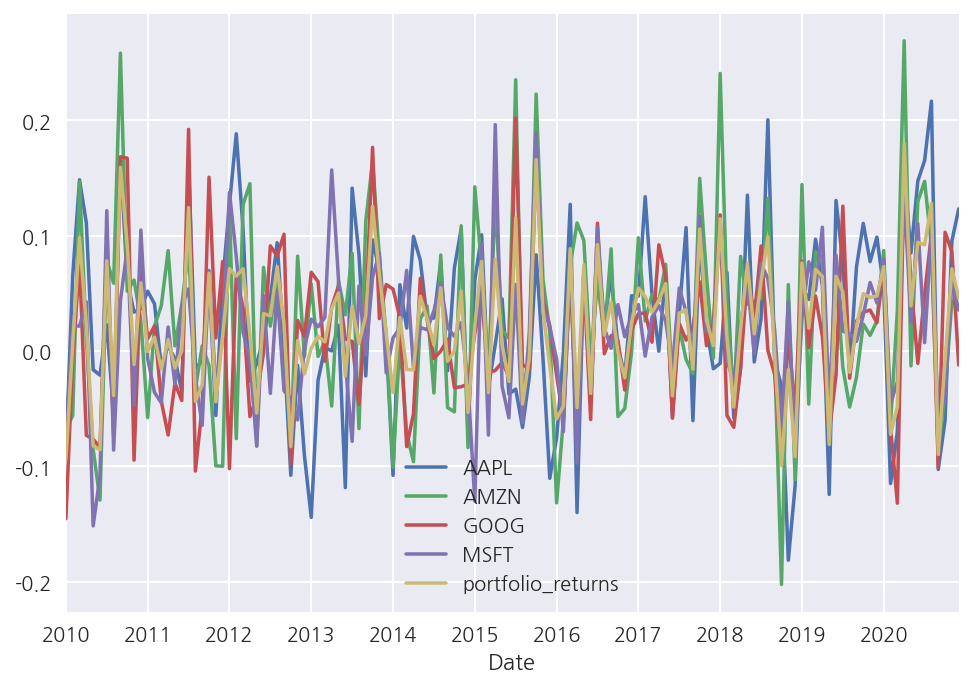

In [53]:
asset_df.plot();

7. Merge the datasets:

이후, **7단계**에서 두 데이터를 병합했습니다.

In [54]:
# 포트폴리오 수익률과 3요인 데이터를 병합
factor_3_df = asset_df.join(factor_3_df).drop(ASSETS, axis=1)

# 열 이름 변경
factor_3_df.columns = ["portf_rtn", "mkt", "smb", "hml", "rf"]

# 초과 수익률 계산
# 포트폴리오 수익률에서 무위험 수익률을 뺌
factor_3_df["portf_ex_rtn"] = (
    factor_3_df["portf_rtn"] - factor_3_df["rf"]
)

8. Define a function for the rolling n-factor model

 **8단계**에서는 롤링 윈도우를 사용하여 $ n $ 요인 모델을 추정하는 함수를 정의했습니다. 주요 아이디어는 우리가 준비한 데이터프레임을 반복 처리하며 각 달에 대해 모델을 추정하는 것입니다. Fama-French 모델은 마지막 5년(60개월)의 데이터를 사용하여 추정되며, 항상 전체 관측값을 포함하도록 60번째 달부터 모델을 추정합니다.

 >적절한 소프트웨어 엔지니어링 관행에 따르면 입력 데이터의 유형이 의도한 대로인지 또는 입력 데이터프레임에 필요한 열이 포함되어 있는지 확인하는 몇 가지 확인 절차를 작성해야 하지만, 우리는 여기서 이러한 작업을 생략했습니다.

In [56]:
def rolling_factor_model(input_data, formula, window_size):
    """
    고정 크기의 롤링 윈도우를 사용하여 Fama-French (n-요인) 모델을 추정하는 함수입니다.
    
    매개변수
    ------------
    input_data : pd.DataFrame
        요인과 자산/포트폴리오 수익률을 포함하는 데이터프레임
    formula : str
        OLS 회귀를 나타내는 `statsmodels` 호환 공식  
    window_size : int
        롤링 윈도우 길이
    
    반환값
    -----------
    coeffs_df : pd.DataFrame
        각 반복에 대한 절편과 세 가지 요인을 포함하는 데이터프레임
    """

    coeffs = []

    for start_ind in range(len(input_data) - window_size + 1):        
        end_ind = start_ind + window_size

        # 회귀 모델 정의 및 적합
        ff_model = smf.ols(
            formula=formula, 
            data=input_data[start_ind:end_ind]
        ).fit()
   
        # 계수 저장
        coeffs.append(ff_model.params)
    
    coeffs_df = pd.DataFrame(
        coeffs, 
        index=input_data.index[window_size - 1:]
    )

    return coeffs_df

9. Estimate the rolling three-factor model and plot the results:

마지막으로, 정의된 함수를 준비된 데이터프레임에 적용하고 결과를 시각화했습니다.

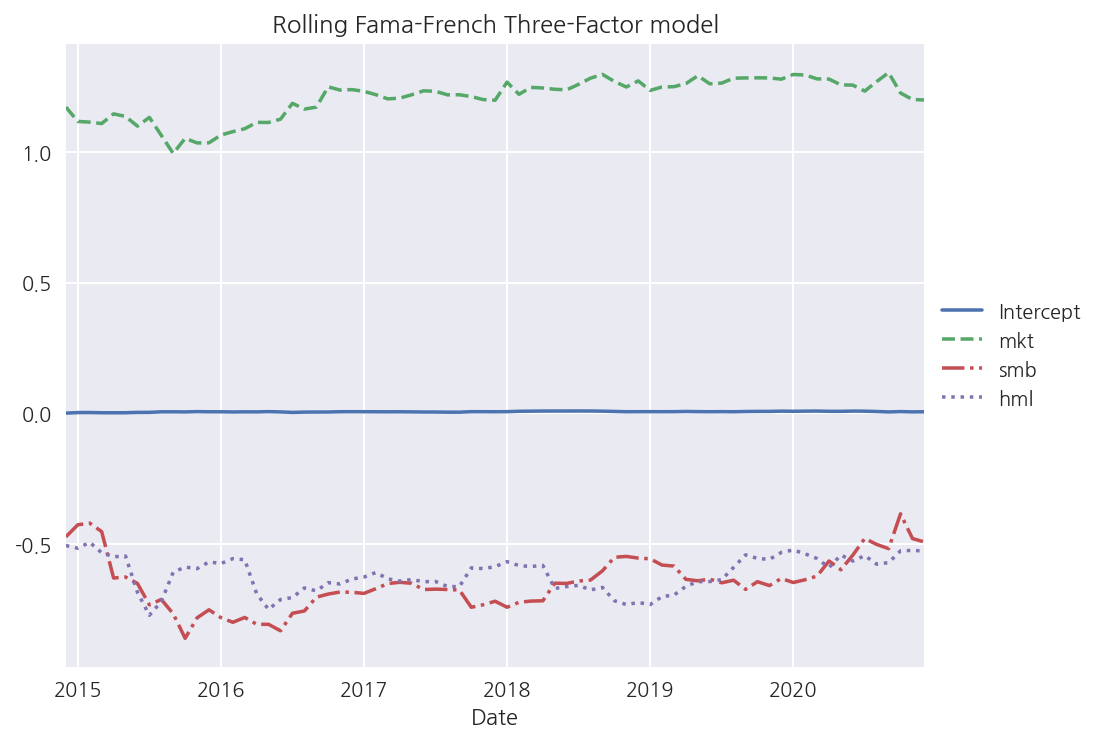

In [57]:
# Fama-French 3요인 모델 공식 정의
MODEL_FORMULA = "portf_ex_rtn ~ mkt + smb + hml"

# 롤링 윈도우 크기 60으로 3요인 모델 추정
results_df = rolling_factor_model(factor_3_df, 
                                  MODEL_FORMULA, 
                                  window_size=60)

# 결과 시각화
(
    results_df
    .plot(title = "Rolling Fama-French Three-Factor model",
          style=["-", "--", "-.", ":"])
    .legend(loc="center left",bbox_to_anchor=(1.0, 0.5))
)

# 그래프 스타일 조정
sns.despine()
plt.tight_layout()

# 그래프 저장 (주석 처리됨)
# plt.savefig("images/figure_9_6", dpi=200)

Figure 8.6: The coefficients of the rolling three-factor model

이전 그래프를 검사해보면 다음과 같은 점을 확인할 수 있습니다:

- 절편은 거의 일정하며 0에 매우 가깝습니다.
- 요인에 다소 변동성이 있지만, 갑작스러운 반전이나 예상치 못한 급등은 없습니다.

## 8.4 Estimating the four- and five-factor models

**4요인 및 5요인 모델 추정**

이번 레시피에서는 Fama-French 3요인 모델의 두 가지 확장을 구현합니다.

먼저, **Carhart의 4요인 모델** 입니다. 이 확장의 기본 가정은 짧은 기간 내에서 승자 주식은 계속 승자로 남고, 패자 주식은 계속 패자로 남는다는 것입니다. 승자와 패자를 분류하는 기준의 예로는 지난 12개월 동안의 누적 총 수익률이 될 수 있습니다.

**모멘텀 요인(WML; Winners Minus Losers)** 은 지난 12개월 동안 승자 주식이 패자 주식보다 더 높은 초과 수익률을 기록한 것을 측정합니다(모멘텀 요인 계산에 대한 참고 사항은 이 레시피의 "참고" 섹션을 참조하세요).

4요인 모델은 다음과 같이 표현할 수 있습니다:

$ E(r_i) - r_f = \alpha + \beta_{mkt}MKT + \beta_{smb}SMB + \beta_{hml}HML + \beta_{wml}WML $

두 번째 확장은 **Fama-French의 5요인 모델** 입니다. Fama와 French는 두 가지 요인을 추가하여 3요인 모델을 확장했습니다:

- **수익성 요인(RMW; Robust Minus Weak)**: 높은 이익률을 가진 회사(Robust)가 낮은 이익률을 가진 회사(Weak)보다 더 높은 초과 수익률을 기록하는 것을 측정합니다(강한 수익성).
- **투자 요인(CMA; Conservative Minus Aggressive)**: 보수적인 투자 정책을 가진 기업이 공격적인 투자 정책을 가진 기업보다 더 높은 초과 수익률을 기록하는 것을 측정합니다.

5요인 모델은 다음과 같이 표현할 수 있습니다:

$ E(r_i) - r_f = \alpha + \beta_{mkt}MKT + \beta_{smb}SMB + \beta_{hml}HML + \beta_{rmw}RMW + \beta_{cma}CMA $

모든 팩터 모델에서, 위험 요인에 대한 노출이 예상 수익률의 가능한 변화를 포착하는 경우, 자산/포트폴리오에 대한 절편($\alpha$)은 0이어야 합니다.

이번 레시피에서는 Amazon의 월별 수익률을 2016년부터 2020년까지 4요인 및 5요인 모델로 설명합니다.

### How to do it...

1. Import the libraries:

In [2]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Specify the risky asset and the time horizon:

**2단계**에서는 고려된 주식과 기간의 티커를 매개변수로 정의했습니다.

In [3]:
RISKY_ASSET = "AMZN"
START_DATE = "2016-01-01"
END_DATE = "2020-12-31"

3. Download the risk factors from prof. French's website:

**3단계**에서는 **pandas_datareader**를 사용하여 필요한 데이터셋을 다운로드했습니다. 이를 통해 CSV 파일을 수동으로 다운로드하지 않고도 무위험 이자율 관련 데이터를 편리하게 다운로드할 수 있었습니다. 이 과정에 대한 자세한 내용은 **Fama-French 3요인 모델 추정** 레시피를 참조하세요.

In [5]:
# 3요인 데이터 다운로드
factor_3_df = web.DataReader("F-F_Research_Data_Factors", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]

# 모멘텀 요인 데이터 다운로드
momentum_df = web.DataReader("F-F_Momentum_Factor", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]
      
# 5요인 데이터 다운로드
factor_5_df = web.DataReader("F-F_Research_Data_5_Factors_2x3", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]

4. Download the data of the risky asset from Yahoo Finance:

**4단계**와 **5단계**에서는 Amazon의 주가를 다운로드하고 이전에 설명한 방법론을 사용하여 월별 수익률을 계산했습니다.

In [6]:
# Yahoo Finance에서 주식 데이터 다운로드
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

# 다운로드된 데이터 행 수 출력
print(f"다운로드된 데이터 행 수: {asset_df.shape[0]}")

다운로드된 데이터 행 수: 1259


5. Calculate monthly returns:

In [8]:
# 월별 수익률 계산
y = asset_df["Adj Close"].resample("M") \
                         .last() \
                         .pct_change() \
                         .dropna()

# 인덱스를 월 단위 기간으로 변환
y.index = y.index.to_period("m")

# 시리즈 이름 지정
y.name = "rtn"

6. Merge the datasets for the four-factor models:

**6단계**와 **7단계**에서는 모든 데이터를 결합하고 열 이름을 변경한 후 초과 수익률을 계산했습니다. **join** 메서드를 사용할 때 **on** 인자를 명시하지 않으면 기본값은 데이터프레임의 인덱스가 됩니다. 우리는 또한 적절한 스케일에 도달하기 위해 Professor French의 웹사이트에서 다운로드한 모든 데이터를 100으로 나누어야 했습니다.

이렇게 해서 4요인 및 5요인 모델에 필요한 모든 입력값을 준비했습니다. **5요인 데이터셋**의 SMB 요인은 3요인 데이터셋에서 계산된 것과 다르게 계산됩니다. 자세한 내용은 이 레시피의 **참고** 섹션에 있는 링크를 참조하세요.

In [9]:
# 모든 데이터셋을 인덱스를 기준으로 결합
factor_4_df = factor_3_df.join(momentum_df).join(y)

# 열 이름 변경
factor_4_df.columns = ["mkt", "smb", "hml", "rf", "mom", "rtn"]

# 수익률을 제외한 모든 값을 100으로 나눔
factor_4_df.loc[:, factor_4_df.columns != "rtn"] /= 100

# 초과 수익률 계산
factor_4_df["excess_rtn"] = (
    factor_4_df["rtn"] - factor_4_df["rf"]
)

# 상위 5개 행 출력
factor_4_df.head()

,mkt,smb,hml,rf,mom,rtn,excess_rtn
Date,,,,,,,
2016-01,-0.0577,-0.0342,0.0209,0.0001,0.0144,-0.131515,-0.131615
2016-02,-0.0007,0.0074,-0.0057,0.0002,-0.0438,-0.058739,-0.058939
2016-03,0.0696,0.0082,0.0119,0.0002,-0.0501,0.074423,0.074223
2016-04,0.0091,0.0076,0.0328,0.0001,-0.0602,0.111094,0.110994
2016-05,0.0178,-0.0017,-0.0166,0.0001,0.0143,0.095817,0.095717


7. Merge the datasets for the five-factor models:

In [10]:
# 인덱스를 기준으로 모든 데이터셋 결합
factor_5_df = factor_5_df.join(y)

# 열 이름 변경
factor_5_df.columns = [
    "mkt", "smb", "hml", "rmw", "cma", "rf", "rtn"
]

# 수익률을 제외한 모든 값을 100으로 나눔
factor_5_df.loc[:, factor_5_df.columns != "rtn"] /= 100

# 초과 수익률 계산
factor_5_df["excess_rtn"] = (
    factor_5_df["rtn"] - factor_5_df["rf"]
)

# 상위 5개 행 출력
factor_5_df.head()

,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
Date,,,,,,,,
2016-01,-0.0577,-0.0347,0.0209,0.0281,0.0307,0.0001,-0.131515,-0.131615
2016-02,-0.0007,0.0088,-0.0057,0.0325,0.0202,0.0002,-0.058739,-0.058939
2016-03,0.0696,0.0107,0.0119,0.0077,-0.0008,0.0002,0.074423,0.074223
2016-04,0.0091,0.0123,0.0328,-0.0297,0.0190,0.0001,0.111094,0.110994
2016-05,0.0178,-0.0061,-0.0166,-0.0109,-0.0249,0.0001,0.095817,0.095717


8. Estimate the four-factor model:

**8단계**와 **9단계**에서는 **statsmodels** 라이브러리의 OLS 회귀 분석 기능을 사용하여 모델을 추정했습니다. 함수적 형태는 절편을 자동으로 회귀 방정식에 추가합니다.

In [11]:
four_factor_model = smf.ols(
    formula="excess_rtn ~ mkt + smb + hml + mom", 
    data=factor_4_df
).fit()

print(four_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     17.79
Date:                Sun, 29 Sep 2024   Prob (F-statistic):           2.01e-09
Time:                        12:39:30   Log-Likelihood:                 89.722
No. Observations:                  60   AIC:                            -169.4
Df Residuals:                      55   BIC:                            -159.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0055      0.008      0.692      0.4

Figure 8.7: The summary of the estimated four-factor model

9. Estimate the five-factor model:

In [12]:
five_factor_model = smf.ols(
    formula="excess_rtn ~ mkt + smb + hml + rmw + cma", 
    data=factor_5_df
).fit()

print(five_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     16.89
Date:                Sun, 29 Sep 2024   Prob (F-statistic):           5.09e-10
Time:                        12:39:35   Log-Likelihood:                 93.061
No. Observations:                  60   AIC:                            -174.1
Df Residuals:                      54   BIC:                            -161.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0058      0.008      0.767      0.4

Figure 8.8: The summary of the estimated five-factor model

5요인 모델에 따르면, Amazon의 초과 수익률은 대부분의 요인(시장 요인을 제외한 모든 요인)에 부정적으로 노출되어 있습니다. 여기서는 계수 해석의 예를 제시합니다. 시장 요인의 수익률이 1% 증가할 때, 우리의 포트폴리오(Amazon 주식)는 무위험 이자율을 초과하여 0.015 퍼센트 포인트의 초과 수익률을 기록할 것입니다. 즉, 1%의 시장 요인 수익률에 대해 Amazon 주식의 초과 수익률은 1.5125 * 1%입니다.

3요인 모델과 마찬가지로, 만약 5요인 모델이 초과 주식 수익률을 완전히 설명한다면, 추정된 절편은 통계적으로 0과 구별되지 않아야 합니다(이 경우에도 해당됩니다).

### See also 

For details on the calculation of the factors, please refer to the following links: 
- Momentum factor: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_mom_factor.html  
- Five-factor model: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html  

For papers introducing the four- and five-factor models, please refer to the following links: 
- Carhart, M. M. (1997), “On Persistence in Mutual Fund Performance,” The Journal of Finance, 52, 1 (1997): 57-82 
- Fama, E. F. and French, K. R. 2015. “A five-factor asset pricing model,” Journal of Financial Economics, 116(1): 1-22: https://doi.org/10.1016/j.jfineco.2014.10.010

## 8.5 Estimating cross-sectional factor models using the Fama-MacBeth regression

**Fama-MacBeth 회귀를 사용한 횡단면 팩터 모델 추정**

이전 레시피에서는 단일 자산 또는 포트폴리오를 종속 변수로 사용하는 다양한 팩터 모델 추정에 대해 다루었습니다. 그러나, 우리는 횡단면(패널) 데이터를 사용하여 여러 자산에 대한 팩터 모델을 한 번에 추정할 수 있습니다.

이 접근 방식을 따르면, 우리는 다음을 할 수 있습니다:

- 포트폴리오가 위험 요인에 얼마나 노출되었는지 추정하고, 그러한 요인들이 포트폴리오의 수익률에 얼마나 영향을 미치는지 알 수 있습니다.
- 시장이 특정 요인에 대한 노출에 대해 지불하는 프리미엄을 알게 됨으로써 주어진 위험을 감수하는 것이 얼마나 가치 있는지 이해할 수 있습니다.

위험 프리미엄을 알면, 포트폴리오가 위험 요인에 얼마나 노출되었는지를 근사하여 해당 포트폴리오의 수익률을 추정할 수 있습니다.

횡단면 회귀를 추정할 때, 선형 회귀의 가정 중 일부가 성립하지 않을 수 있어 여러 문제가 발생할 수 있습니다. 다음과 같은 문제들을 만날 수 있습니다:

- 이분산성과 자기 상관으로 인해 잔차의 공분산 발생
- 다중 공선성
- 측정 오류

이러한 문제를 해결하기 위해 **Fama-MacBeth 회귀**라는 기술을 사용할 수 있습니다. 이 방법은 특정 위험 요인에 대한 시장의 노출에 대해 보상하는 프리미엄을 추정하기 위해 설계된 두 단계 절차입니다.

단계는 다음과 같습니다:

1. N(포트폴리오/자산의 수)개의 초과 수익률에 대한 시계열 회귀를 추정하여 요인 로딩을 얻습니다:
   $
   r_i = F * \beta_i + \epsilon_i
   $

2. 각 기간에 대해 한 번씩, T(기간 수)개의 횡단면 회귀를 추정하여 위험 프리미엄을 얻습니다:
   $
   r_t = \hat{\beta} * \lambda_t
   $

이 레시피에서는 5개의 위험 요인과 12개의 산업 포트폴리오 수익률을 사용하여 Fama-MacBeth 회귀를 추정합니다. 이 데이터는 Professor French의 웹사이트에서도 사용할 수 있습니다.

### How to do it...

1. Import the libraries:

In [13]:
# pandas 라이브러리 가져오기
import pandas as pd

# pandas_datareader에서 데이터 모듈 가져오기
import pandas_datareader.data as web

# linearmodels 패키지에서 LinearFactorModel 가져오기
from linearmodels.asset_pricing import LinearFactorModel

2. Specify the time horizon:

1단계와 2단계에서는 필요한 라이브러리를 가져오고, 우리의 분석 시작일과 종료일을 정의했습니다. 총 11년간의 월별 데이터를 사용할 것이며, 이는 132개의 변수 관측치(T로 표시됨)를 생성합니다. 종료일로는 2020년 12월을 명시해야 했습니다. 2020만 입력하면 2020년 1월로 종료되는 데이터셋이 다운로드됩니다.

In [14]:
START_DATE = "2010"
END_DATE = "2020-12"

3. Download and adjust the risk factors from prof. French's website:

**3단계**에서는 **pandas_datareader**를 사용하여 5요인 데이터셋을 다운로드했습니다. 값을 100으로 나누어 백분율로 표현하도록 조정했습니다.


In [16]:
# Fama-French 5요인 데이터 다운로드
# "F-F_Research_Data_5_Factors_2x3" 데이터셋을 famafrench 데이터 소스에서 가져옴
# 지정된 시작일과 종료일 사이의 데이터를 가져옴
# 데이터를 100으로 나누어 백분율로 변환
factor_5_df = (
    web.DataReader("F-F_Research_Data_5_Factors_2x3", 
                   "famafrench", 
                   start=START_DATE, 
                   end=END_DATE)[0]
    .div(100)
)

# 데이터의 처음 5행을 출력하여 확인
factor_5_df.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2010-01,-0.0336,0.0034,0.0043,-0.0127,0.0046,0.0000
2010-02,0.0340,0.0151,0.0322,-0.0027,0.0142,0.0000
2010-03,0.0631,0.0185,0.0221,-0.0065,0.0169,0.0001
2010-04,0.0200,0.0498,0.0289,0.0069,0.0172,0.0001
2010-05,-0.0789,0.0005,-0.0244,0.0130,-0.0022,0.0001


4. Download and adjust the returns of 12 Industry Portfolios from prof. French's website:

**4단계**에서는 Prof. French의 웹사이트에서 12개 산업 포트폴리오의 수익률을 다운로드했습니다(데이터셋에 대한 자세한 내용은 "참고" 섹션을 참조하세요). 각 포트폴리오 데이터셋 열에서 무위험 이자율(팩터 데이터셋에서 이용 가능)을 빼서 초과 수익률을 계산했습니다. **sub** 메서드를 사용하면 시계열이 정확히 일치하는지 쉽게 확인할 수 있습니다.

In [17]:
# 12개 산업 포트폴리오 데이터 다운로드 및 처리
# - 각 산업별 월간 수익률 데이터를 포함
# - 초과 수익률 계산을 통해 위험 프리미엄 분석에 사용 가능
portfolio_df = (
    web.DataReader("12_Industry_Portfolios", 
                   "famafrench", 
                   start=START_DATE, 
                   end=END_DATE)[0]
    .div(100)  # 백분율로 변환
    .sub(factor_5_df["RF"], axis=0)  # 무위험 수익률 차감하여 초과 수익률 계산
)

# 처리된 데이터의 첫 5행 출력
portfolio_df.head()

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
Date,,,,,,,,,,,,
2010-01,-0.0240,-0.0043,-0.0446,-0.0484,-0.0117,-0.0791,-0.0672,-0.0444,-0.0184,-0.0002,-0.0065,-0.0030
2010-02,0.0266,0.0739,0.0585,0.0261,0.0404,0.0485,0.0276,-0.0042,0.0430,0.0038,0.0291,0.0475
2010-03,0.0588,0.0934,0.0782,0.0322,0.0408,0.0667,0.0762,0.0311,0.0625,0.0362,0.0830,0.0778
2010-04,-0.0103,0.0725,0.0415,0.0404,0.0131,0.0229,0.0340,0.0284,0.0254,-0.0219,0.0112,0.0290
2010-05,-0.0574,-0.0907,-0.0926,-0.1028,-0.0679,-0.0780,-0.0587,-0.0630,-0.0537,-0.0807,-0.0911,-0.0821


5. Drop the risk-free rate from the factor data set:

**5단계**에서는 무위험 이자율을 제외했습니다. 더 이상 사용하지 않을 것이기 때문에, DataFrame에 불필요한 열이 없으면 Fama-MacBeth 회귀 모델을 더 쉽게 추정할 수 있습니다.

In [18]:
# 무위험 이자율(RF) 열을 factor_5_df에서 제거
factor_5_df = factor_5_df.drop("RF", axis=1)

# 수정된 factor_5_df의 처음 5행을 출력하여 확인
factor_5_df.head()

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02,0.0340,0.0151,0.0322,-0.0027,0.0142
2010-03,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05,-0.0789,0.0005,-0.0244,0.0130,-0.0022


6. Estimate the Fama-MacBeth regression and print the summary:

마지막 단계에서는 **LinearFactorModel** 클래스의 객체를 생성하고 두 데이터셋을 인자로 제공했습니다. 그런 다음 **fit** 메서드를 사용하여 모델을 추정하고, 요약을 출력했습니다.

>**linear models**와 **scikit-learn** 사이의 작은 차이를 발견할 수 있을 것입니다. 후자의 경우 **fit** 메서드를 호출할 때 데이터를 제공해야 합니다. **linear models**의 경우 **LinearFactorModel** 인스턴스를 생성할 때 데이터를 제공해야 했습니다.

>**linear models**에서는 **statsmodels**에서처럼 **formula notation**을 사용할 수도 있습니다. 이를 위해서는 **from_formula** 메서드를 사용해야 합니다. 예제는 다음과 같습니다:  ```python LinearFactorModel.from_formula(formula, data) ``` 여기서 **formula**는 수식을 포함한 문자열이며, **data**는 포트폴리오/자산 및 요인이 포함된 객체입니다.

In [19]:
# 5요인 모델 생성
five_factor_model = LinearFactorModel(
    portfolios=portfolio_df,  # 포트폴리오 데이터
    factors=factor_5_df  # 요인 데이터
)

# 모델 적합
result = five_factor_model.fit()

# 결과 출력
print(result)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 12   R-squared:                      0.7908
No. Factors:                          5   J-statistic:                    9.9201
No. Observations:                   132   P-value                         0.1931
Date:                  Sun, Sep 29 2024   Distribution:                  chi2(7)
Time:                          13:28:22                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.0123     0.0038     3.2628     0.0011      0.0049      0.0198
SMB           -0.0064     0.0052    

Figure 8.9: The results of the Fama-MacBeth regression

We can also print the full summary (1 aggregate and 12 individual ones for each portfolio separately).

테이블의 결과는 T개의 횡단면 회귀에서 도출된 평균 위험 프리미엄입니다.

우리는 전체 요약(위험 프리미엄과 각 포트폴리오의 요인 로딩을 포함한)을 출력할 수도 있습니다. 이를 위해 다음 코드를 실행해야 합니다:

In [20]:
print(result.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 12   R-squared:                      0.7908
No. Factors:                          5   J-statistic:                    9.9201
No. Observations:                   132   P-value                         0.1931
Date:                  Sun, Sep 29 2024   Distribution:                  chi2(7)
Time:                          13:28:22                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.0123     0.0038     3.2628     0.0011      0.0049      0.0198
SMB           -0.0064     0.0052    

### There's more

우리는 이미 **linear models** 라이브러리를 사용하여 Fama-MacBeth 회귀를 추정했습니다. 그러나 두 단계를 수동으로 수행하면 절차를 더 잘 이해하는 데 도움이 될 수 있습니다.

1. Import the libraries:

In [23]:
# statsmodels.api에서 OLS와 add_constant를 가져옵니다
# OLS는 일반 최소 제곱법을 수행하는 데 사용됩니다
# add_constant는 회귀 분석을 위해 상수항을 추가하는 데 사용됩니다
from statsmodels.api import OLS, add_constant

2. First step - estimate the factor loadings:

In [24]:
# 각 포트폴리오에 대한 요인 로딩을 계산합니다
factor_loadings = []
for portfolio in portfolio_df:
    # OLS 회귀를 수행합니다
    reg_1 = OLS(
        endog=portfolio_df.loc[:, portfolio],  # 종속 변수: 포트폴리오 수익률
        exog=add_constant(factor_5_df)  # 독립 변수: 5요인 + 상수항
    ).fit()
    # 상수항을 제외한 요인 로딩을 저장합니다
    factor_loadings.append(reg_1.params.drop("const"))

3. Store the factor loadings in a DataFrame:

In [25]:
# 요인 로딩을 DataFrame으로 저장
factor_load_df = pd.DataFrame(
    factor_loadings,  # 계산된 요인 로딩 리스트
    columns=factor_5_df.columns,  # 열 이름은 5요인 DataFrame의 열 이름과 동일
    index=portfolio_df.columns  # 인덱스는 포트폴리오 DataFrame의 열 이름(포트폴리오 이름)
)

# 요인 로딩 DataFrame의 상위 5행 출력
factor_load_df.head()

,Mkt-RF,SMB,HML,RMW,CMA
NoDur,0.786477,-0.224060,-0.082485,0.470981,0.329098
Durbl,1.557110,0.558580,-0.169151,0.297248,0.319242
Manuf,1.101314,0.294820,0.149646,0.079494,-0.009732
Enrgy,1.248843,0.496143,0.632640,0.243634,0.399419
Chems,0.880427,-0.105721,-0.018053,0.155062,0.225931


Figure 8.10: First step of the Fama-MacBeth regression—the estimated factor loadings

우리는 이 숫자들을 linearmodels 라이브러리의 전체 요약 출력과 비교할 수 있습니다.

4. Second step - estimate the risk premia:

In [26]:
# 위험 프리미엄을 저장할 빈 리스트 생성
risk_premia = []

# 각 기간에 대해 반복
for period in portfolio_df.index:
    # OLS 회귀 수행
    reg_2 = OLS(
        endog=portfolio_df.loc[period, factor_load_df.index],  # 종속 변수: 특정 기간의 포트폴리오 수익률
        exog=factor_load_df  # 독립 변수: 요인 로딩
    ).fit()
    
    # 회귀 결과의 계수(위험 프리미엄)를 리스트에 추가
    risk_premia.append(reg_2.params)

5. Store the risk premia in a DataFrame:

In [27]:
# 위험 프리미엄을 DataFrame으로 저장
risk_premia_df = pd.DataFrame(
    risk_premia,  # 계산된 위험 프리미엄 리스트
    index=portfolio_df.index,  # 인덱스는 포트폴리오 DataFrame의 인덱스와 동일
    columns=factor_load_df.columns.tolist())  # 열 이름은 요인 로딩 DataFrame의 열 이름과 동일

# 위험 프리미엄 DataFrame의 상위 5행 출력
risk_premia_df.head()

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01,-0.029810,0.055069,-0.023958,-0.041338,0.012765
2010-02,0.037031,0.021759,-0.014474,0.026292,-0.031823
2010-03,0.065399,-0.031192,-0.003587,-0.002300,-0.004288
2010-04,0.018661,0.047772,0.009254,0.040722,-0.017509
2010-05,-0.077033,0.023324,-0.020309,0.021153,-0.013902


Figure 8.11: Second step of the Fama-MacBeth regression—the estimated risk premiums over time

6. Calculate the average risk premia:

In [28]:
# 위험 프리미엄의 평균 계산
# 각 요인에 대한 평균 위험 프리미엄을 구함
risk_premia_df.mean()

Mkt-RF    0.012342
SMB      -0.006363
HML      -0.008861
RMW      -0.001117
CMA      -0.002430
dtype: float64

위에서 계산된 위험 프리미엄은 linearmodels 라이브러리에서 얻은 결과와 일치합니다.

### See also
- **linear models** 라이브러리의 문서는 패널 회귀 모델을 학습하는 데 좋은 자료입니다(뿐만 아니라 도구 변수 모델 등에 대한 유틸리티도 포함되어 있습니다). Python에서의 구현에 대한 문서는 [여기](https://bashtage.github.io/linearmodels/index.html)에서 확인할 수 있습니다.
- 12개 산업 포트폴리오 데이터셋에 대한 설명: [여기](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library/det_12_ind_port.html)를 참조하세요.

Fama-MacBeth 절차에 대한 추가 읽을거리:
- Fama, E. F., and MacBeth, J. D., “Risk, return, and equilibrium: Empirical tests,” *Journal of Political Economy*, 81, 3 (1973): 607-636
- Fama, E. F., “Market efficiency, long-term returns, and behavioral finance,” *Journal of Financial Economics*, 49, 3 (1998): 283-306

## Summary
이 장에서는 가장 대중적인 팩터 모델 중 일부를 구축했습니다. 가장 간단한 단일 팩터 모델(CAPM)로 시작한 후, 더 고급화된 3요인, 4요인, 5요인 모델에 접근하는 방법을 설명했습니다. 또한 Fama-MacBeth 회귀를 사용하여 적절한 횡단면(패널) 데이터를 사용해 여러 자산에 대한 팩터 모델을 추정하는 방법도 설명했습니다.